# <center> Sentiment Analysis </center>
We seek to assess the accuracy of classification performance of a well tuned base BERT Transformer with Tensorflow.<br> We will be using the [Rotten Tomatoes movie reviews dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) for the analysis <br>.
This excercise is performed across three phases:
<ol>
    <li> Data Transformation - Data Loading + EDA + Tokenization </li>
    <li> Model Building and Training </li>
    <li> Prediction </li>
</ol>

## Part 1- Data Transformation - Data Loading + EDA + Tokenization

In [94]:
%config Completer.use_jedi = False

In [95]:
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np
import zipfile
import pandas as pd

In [96]:
api = KaggleApi()
api.authenticate()

### I. Load the data
#### Extract using Kaggle API 
The path for the data is: sentiment-analysis-on-movie-reviews

In [97]:
names=['train.tsv', 'test.tsv']
for name in names:
    api.competition_download_file('sentiment-analysis-on-movie-reviews',file_name=name+'.zip',path='./')
    with zipfile.ZipFile(name+'.zip','r') as z:
        z.extractall('./')

train.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)


### II. Exploratory Data Analysis on the training data set

In [98]:
df_sent=pd.read_csv('train.tsv',sep='\t')
df_sent.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [99]:
print(f'The total number of samples available: {len(df_sent["SentenceId"])}')
print(f'The total unique number of samples available: {len(df_sent["SentenceId"].unique())}')

The total number of samples available: 156060
The total unique number of samples available: 8529


Hence, on an average, there are around 18.3 duplicates per unique sentence. However, in the case of the SentenceId 1, we see that even the sentiment label changes from the first sample to the second

In [100]:
count_unique_per_id=[]
for i in df_sent['SentenceId']:
    count_unique_per_id.append(df_sent[df_sent['SentenceId']==i]['Sentiment'].nunique())

In [101]:
unique, counts = np.unique(count_unique_per_id, return_counts=True)
for i,count in enumerate(counts):
    print(f'No. of unique sentiments: {i+1},\tCount of instances: {count},\t %contribution: {count*100/np.sum(counts):.2f}%')

No. of unique sentiments: 1,	Count of instances: 1304,	 %contribution: 0.84%
No. of unique sentiments: 2,	Count of instances: 17694,	 %contribution: 11.34%
No. of unique sentiments: 3,	Count of instances: 71479,	 %contribution: 45.80%
No. of unique sentiments: 4,	Count of instances: 55922,	 %contribution: 35.83%
No. of unique sentiments: 5,	Count of instances: 9661,	 %contribution: 6.19%


In [102]:
import matplotlib.pyplot as plt

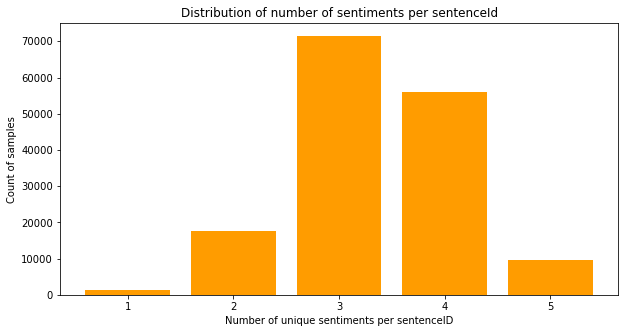

In [103]:
plt.figure(figsize=(10, 5))
plt.bar(unique,counts,color='#ff9c00')
plt.title('Distribution of number of sentiments per sentenceId')
plt.xlabel('Number of unique sentiments per sentenceID')
plt.ylabel('Count of samples')
plt.show();

So clearly:
<ul>
    <li> a Majority of unique sentences have 3 different sentiments for multiple terms removed from the original phrase.</li><li>This can be <b>useful</b> to the model to determine which words trigger which sentiments. Hence, we retain these samples </li>
    <li>Only 1304 sentence ids have only one unique id. This is less than 1% of the samples</li>

</ul>

In [104]:
total_sent=len(np.unique(df_sent['SentenceId'])) #Total number of unique sentence Ids
total_sent

8529

In [105]:
counts= np.array([df_sent.groupby('SentenceId')['SentenceId'].transform('count')]) #find array which has the number of each sentence id
counts

array([[63, 63, 63, ..., 21, 21, 21]], dtype=int64)

In [106]:
unique_sent=len(np.where(counts==1)[0]) #Find sentence ids occuring only once 

In [107]:
print(f'No. of sentences where more than one sentiment is attached to one sentence id is: {total_sent-unique_sent}')

No. of sentences where more than one sentiment is attached to one sentence id is: 8480


Out of the 8529 unique sentences, 8480 have multiple sentiments (99.4% of the data) has multiple, non-unique sentiments

2    50.994489
3    21.098936
1    17.475971
4     5.899013
0     4.531590
Name: Sentiment, dtype: float64


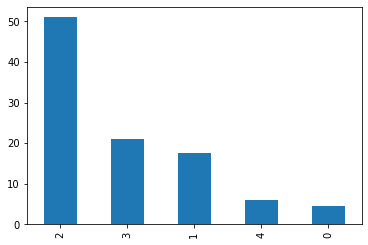

In [108]:
a=df_sent['Sentiment'].value_counts()*100/len(df_sent['Sentiment'])
print(a)
a.plot(kind='bar');

From the Kaggle site:<br>
The sentiment labels are:<br>
0 - negative<br>
1 - somewhat negative<br>
2 - neutral<br>
3 - somewhat positive<br>
4 - positive<br>

Hence, we see that most of the samples (51%) have a neutral sentiment which seems to be appropriate since most of the words in the English language have a neutral tone

### III. Tokenization

We need to create tokens for the input column <b> Phrase </b> and the one hot key representation of the target label <b> Sentiment </b>

In [109]:
from transformers import BertTokenizer

#### Tokenizing input Phrase

In [110]:
tokenizer=BertTokenizer.from_pretrained('bert-base-cased')

In [111]:
tokens=tokenizer(df_sent['Phrase'].tolist(),max_length=512,padding='max_length',add_special_tokens=True,return_tensors='np',truncation=True)

In [112]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [113]:
#On a sample basis, check if attention masks have been applied correctly i.e. attention mask = 0 only if the input id is padded
import random
r=list(range(len(tokens['input_ids'])))
[tokens['input_ids'][i].tolist().index(0)==tokens['attention_mask'][i].tolist().index(0) for i in np.random.choice(r,size=10)]

[True, True, True, True, True, True, True, True, True, True]

In [114]:
type(tokens['input_ids']) #Re-check if return tensors are correct

numpy.ndarray

#### One hot key encoding of <b> Sentiment </b>

In [115]:
###One hot key representation for Sentiment column
def OHK(array,vocab_size):
    ohk=np.zeros((len(array),vocab_size))
    ohk[range(len(array)),array]=1
    return ohk

In [116]:
df_sent['Sentiment'].max()

4

In [117]:
sentiment =OHK(df_sent['Sentiment'],df_sent['Sentiment'].max()+1) #Create one hot key for Sentiment column

In [118]:
r=list(np.random.choice(df_sent['Sentiment'],10)) #Check accuracy of the one hot key encoding
print(np.squeeze([df_sent['Sentiment'][i]==np.where(sentiment[i]==1) for i in r]))

[ True  True  True  True  True  True  True  True  True  True]


#### Storing all required inputs and labels at disk

We need only the input_ids and attenion mask arrays as inputs from the 'Phrase' column and the one hot key representation of the 'Sentiment' column as the output for the analysis 

In [119]:
file_names=['input_ids','attention_mask']

for file in file_names:
    with open(str(file)+'.npy','wb') as f:
        np.save(f,tokens[file])
with open('sentiment.npy','wb') as f:
    np.save(f,sentiment)

In [120]:
def test_process(test_csv_name): #Creating a single function for all text processing for the test data
    df=pd.read_csv(test_csv_name,sep='\t')
    from transformers import BertTokenizer
    tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
    tokens_test=tokenizer(df['Phrase'].tolist(),max_length=512,padding='max_length',add_special_tokens=True,return_tensors='np',truncation=True)
    sentiment=OHK(df['Sentiment'],df['Sentiment'].max()+1)
    with open('test_input_ids.npy','wb') as f:
        np.save(f,tokens_test['input_ids'])
    with open('test_attention_masks.npy','wb') as f:
        np.save(f,tokens_test['attention_mask'])
    with open('test_sentiment.npy','wb') as f:
        np.save(f,sentiment)

### IV. Batch creation

In [121]:
with open('input_ids.npy','rb') as f:
    movie_ids=np.load(f, allow_pickle=True)
with open('attention_mask.npy','rb') as f:
    attention_masks=np.load(f, allow_pickle=True)
with open('sentiment.npy','rb') as f:
    labels=np.load(f, allow_pickle=True)

In [122]:
print(movie_ids.shape)
print(attention_masks.shape)
print(labels.shape)

(156060, 512)
(156060, 512)
(156060, 5)


In [123]:
#Creating the equivalent of a zipped (inputs, outputs) file for the inputs and outputs to feed into tensorflow
import tensorflow as tf
trainset=tf.data.Dataset.from_tensor_slices((movie_ids,attention_masks,labels))

In [124]:
trainset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int32, tf.int32, tf.float64)>

#### Hence, from_tensor_slices kinda acts like a zip of the two inputs and the output. So the first sample of the dataset has the first element of movie_ids, the first element of the attention masks and the first element of labels

In [125]:
trainset.element_spec

(TensorSpec(shape=(512,), dtype=tf.int32, name=None),
 TensorSpec(shape=(512,), dtype=tf.int32, name=None),
 TensorSpec(shape=(5,), dtype=tf.float64, name=None))

##### So indirectly, we see that the trainset has three tensors: first two with a shape of (512,) [movie id and attention mask] and a third with a shape of 5 [One hot key representation of the labels]

##### Tensorflow requires the data to be provided as input, labels. However, since we have two inputs and one output, we provide it as an input dictionary and an output tensor

In [126]:
def transform_io(ids,mask,label):
    return ({'ids':ids,'masks':mask},label)

In [127]:
trainset=trainset.map(transform_io)

In [128]:
trainset.element_spec

({'ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None),
  'masks': TensorSpec(shape=(512,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(5,), dtype=tf.float64, name=None))

##### Now, we see that the content has changed from three tensors to one dictionary of two tensors, each of shape (512,) and one tensor of shape (5,)

#### Shuffling and creating batches

In [129]:
batch_size=32

In [130]:
ref_set=trainset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

In [131]:
ref_set

<BatchDataset shapes: ({ids: (32, 512), masks: (32, 512)}, (32, 5)), types: ({ids: tf.int32, masks: tf.int32}, tf.float64)>

#### Spliting into train and validation sets

In [132]:
#We need a split that will give us a multiple of the batch_size
split=0.9
int(movie_ids.shape[0]*0.9/batch_size)

4389

In [133]:
train_set=ref_set.take(4389)
validate_set=ref_set.skip(4389)
type(train_set)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [134]:
print(train_set.element_spec)
print(validate_set.element_spec)

({'ids': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None), 'masks': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))
({'ids': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None), 'masks': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))


In [135]:
tf.data.experimental.save(train_set,'train')
tf.data.experimental.save(validate_set,'validate')

In [136]:
with open('train_element_spec.txt','w') as f:
    f.write(str(train_set.element_spec))
with open('validate_element_spec.txt','w') as f:
    f.write(str(validate_set.element_spec))